In [1]:
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from segnet import segnet
from generator import DataGenerator

Using TensorFlow backend.


In [3]:
# hyperparameters
nv=int(2**16) # variants
na=3          # alleles
nc=4          # ancestry classes
ne=100         # number of epochs
gen=True      # use data generator
hor=True      # use multi-gpu

In [4]:
# configure horovod if we're using multiple gpus
# - note that this doesn't work within a jupyter notebook
# - but you can use it to assign one of the two gpus to the tf instance
# - ((probably))
if hor: 
    import horovod.keras as hvd 

    # initialize horovod instance -- this currently only works on galangal
    hvd.init()

    # assign GPUs to horovod 
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        # tf.config in tf <= 1.6
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# sanity check that we're on gpu
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# declare model
model=segnet(input_shape=(nv, na), n_classes=nc, n_filters=8)

# and optimizer
if hor:
    adam=optimizers.Adam(lr=1e-4 * hvd.size())
    adam=hvd.DistributedOptimizer(adam)
else:
    adam=optimizers.Adam(lr=1e-4)

# now compile and show parameter summary
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

Model: "segnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65536, 3)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 65536, 3)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_down1 (Conv1D)            (None, 65536, 8)     392         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 65536, 8)     0           conv1_down1[0][0]                
_____________________________________________________________________________________________

In [6]:
# load data
data_root='/home/magu/deepmix/data/ALL_DNA_dataset/'
X = np.load(data_root+'unzipped/chm_21.genotypes.npy', mmap_mode='r')
Y = np.load(data_root+'unzipped/chm_21.labels.npy', mmap_mode='r')
S = np.load(data_root+'unzipped/chm_21.samples.npy')
print([X.shape, Y.shape, X.shape])

[(5008, 1105538, 7), (5008, 1105538, 5), (5008, 1105538, 7)]


In [7]:
# and train individuals
train=np.loadtxt(data_root+'chm21.train.txt', dtype=str)
train_ix=[i for i,q in enumerate(train) if q in S]
print(len(train_ix))

3428


In [51]:
# and some dev individuals, why not -- first pick their indexes
n=100
S=np.load(data_root+'simulated/label/dev_10gen.result.npz')['S']
s=np.random.choice(S, size=n, replace=False)

# then load and subset -- AMR is the first ancestry label, ignored for now
x_f=data_root+'simulated/numpy/dev_10gen.query.ALL_X.npz'
y_f=data_root+'simulated/label/dev_10gen.result.npz'
S_f=np.load(x_f)['S']
X_dev=np.load(x_f)['G'][[np.where(S_f==(i))[0][0] for i in s],:nv,:na]
S_f=np.load(y_f)['S']
Y_dev=to_categorical(np.load(y_f)['L'][[np.where(S_f==(i))[0][0] for i in s],:nv], dtype='bool')[:,:,1:]
print([X_dev.shape, Y_dev.shape])

[(100, 65536, 3), (100, 65536, 4)]


In [8]:
# now try it out!
if gen:
    params={'X':X, 'Y':Y, 'dim':nv, 'batch_size':32, 'n_classes':nc, 'n_alleles':na}
    generator=DataGenerator(train_ix, **params)
    history=model.fit_generator(generator=generator, epochs=ne, validation_data=(X_dey, Y_dev))
else:
    history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,1:], batch_size=4, epochs=ne)

Epoch 1/50
107/107 [==============================] - 176s 2s/step - loss: 1.1302 - accuracy: 0.2825
Epoch 2/50
107/107 [==============================] - 112s 1s/step - loss: 1.1238 - accuracy: 0.2404
Epoch 3/50
107/107 [==============================] - 113s 1s/step - loss: 1.1214 - accuracy: 0.2392
Epoch 4/50
107/107 [==============================] - 112s 1s/step - loss: 1.1205 - accuracy: 0.2385
Epoch 5/50
107/107 [==============================] - 112s 1s/step - loss: 1.1201 - accuracy: 0.2407
Epoch 6/50
107/107 [==============================] - 112s 1s/step - loss: 1.1203 - accuracy: 0.2373
Epoch 7/50
107/107 [==============================] - 113s 1s/step - loss: 1.1202 - accuracy: 0.2401
Epoch 8/50
107/107 [==============================] - 113s 1s/step - loss: 1.1198 - accuracy: 0.2416
Epoch 9/50
107/107 [==============================] - 115s 1s/step - loss: 1.1186 - accuracy: 0.2647
Epoch 10/50
107/107 [==============================] - 115s 1s/step - loss: 1.1122 - accura

0.8950451612472534


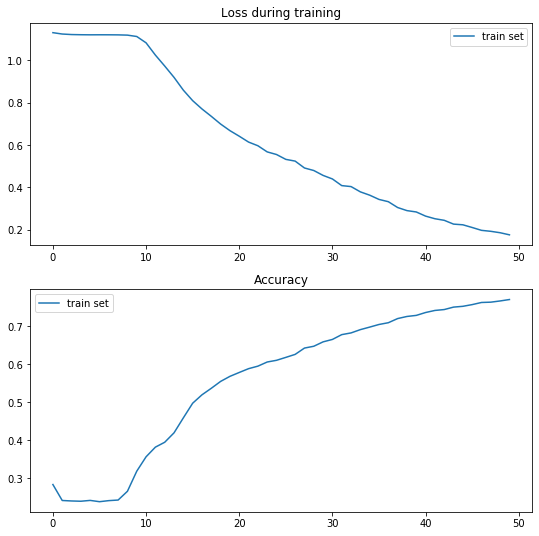

In [60]:
_, dev_acc = model.evaluate(X_dev, Y_dev, verbose=0)

# 1.1) plot loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, (9,9))
plt.subplot(211)
plt.title('Loss during training')
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='dev set')
plt.legend()

# 1.2) plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train set')
plt.plot(history.history['val_accuracy'], label='dev set')
plt.legend()

print(dev_acc)

In [61]:
Y_hat_p=model.predict(X_dev)
Y_hat=np.argmax(Y_hat_p, axis=-1)

In [62]:
Y_hat.shape

(100, 65536)

In [63]:
for i in range(Y_hat.shape[0]):
    print((i, [np.count_nonzero(Y_hat[i,:]==j) for j in range(Y_hat_p.shape[-1])], 
           [np.count_nonzero(Y_dev[i,:,:].argmax(axis=-1)==j) for j in range(Y_hat_p.shape[-1])]))

(0, [0, 0, 8185, 57351], [0, 0, 0, 65536])
(1, [13829, 50937, 679, 91], [16310, 49226, 0, 0])
(2, [0, 0, 65536, 0], [0, 0, 65536, 0])
(3, [65536, 0, 0, 0], [65536, 0, 0, 0])
(4, [16619, 5698, 36755, 6464], [34671, 0, 30865, 0])
(5, [0, 0, 65373, 163], [0, 0, 65536, 0])
(6, [0, 0, 65536, 0], [0, 0, 65536, 0])
(7, [0, 6055, 16746, 42735], [0, 0, 0, 65536])
(8, [0, 65536, 0, 0], [0, 65536, 0, 0])
(9, [0, 65522, 14, 0], [0, 65536, 0, 0])
(10, [0, 58400, 7136, 0], [0, 65536, 0, 0])
(11, [0, 0, 65536, 0], [0, 0, 65536, 0])
(12, [65536, 0, 0, 0], [65536, 0, 0, 0])
(13, [65536, 0, 0, 0], [65536, 0, 0, 0])
(14, [0, 1854, 40440, 23242], [0, 0, 0, 65536])
(15, [0, 0, 65536, 0], [0, 0, 65536, 0])
(16, [0, 58400, 7136, 0], [0, 65536, 0, 0])
(17, [65536, 0, 0, 0], [65536, 0, 0, 0])
(18, [0, 0, 65536, 0], [0, 0, 65536, 0])
(19, [0, 0, 65536, 0], [0, 0, 65536, 0])
(20, [65536, 0, 0, 0], [65536, 0, 0, 0])
(21, [0, 58400, 7136, 0], [0, 65536, 0, 0])
(22, [65530, 0, 0, 6], [65536, 0, 0, 0])
(23, [0, 5840

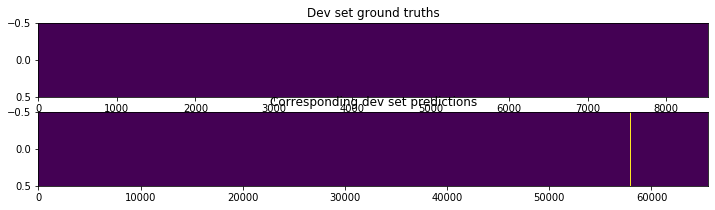

In [74]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[46:47,:].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[46:47,:].astype(int), aspect='auto')#, cmap='jet')

In [65]:
np.where(np.argmax(Y_hat_p[46,:,:], axis=-1)==3)

(array([57534, 57535, 57536, 57537, 57541, 57542, 57543, 57676, 57677,
        57678, 57679, 57690, 57691, 57692, 57702, 57714, 57724, 57771,
        57772, 57778, 57779, 57780, 57781, 57782, 57784, 57785, 57786,
        57787, 57788, 57789, 57790, 57791, 57792, 57793, 57794, 57795,
        57796, 57802, 57803, 57843, 57882, 57883, 57890, 57891, 57905,
        57906, 57907, 57912, 57916, 57917, 57918, 57919, 57920, 57921,
        57922, 57923, 57924, 57925, 57928, 57929, 57930, 57931, 57932,
        57933, 57935, 57936, 57937, 57940, 57941, 57942, 57943, 57949,
        57954, 57955, 57957, 57958, 57959, 57960, 57961, 57963, 57964,
        57965, 57966, 57967, 57968, 57969, 57970, 57971, 57972, 57973,
        57974, 57975, 57976, 57977, 57978, 57979, 57980, 57981, 57983,
        57984, 57985, 57986, 57987, 57988, 57989, 57990, 57991, 57992,
        57993, 57994, 57995, 57996, 57997, 57998, 58000, 58032, 58036,
        58037, 58038, 58039, 58040, 58041, 58044, 58045, 58046, 58047,
      

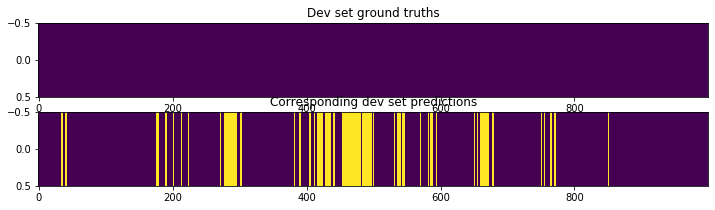

In [75]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[46:47,57500:58500].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[46:47,57500:58500].astype(int), aspect='auto')#, cmap='jet')

In [64]:
Y_hat_p[46,np.where(np.argmax(Y_hat_p[46,:,:], axis=-1)==3),:]

array([[[0.08213563, 0.03751599, 0.41983905, 0.46050936],
        [0.08442739, 0.03778391, 0.41895106, 0.4588377 ],
        [0.07756697, 0.03825476, 0.42215565, 0.4620226 ],
        [0.08144478, 0.03709413, 0.41963056, 0.46183056],
        [0.08412994, 0.03623831, 0.4295293 , 0.45010245],
        [0.07068453, 0.03938501, 0.41830742, 0.47162303],
        [0.08393157, 0.03999302, 0.43248793, 0.44358742],
        [0.10551558, 0.03331598, 0.42205355, 0.43911487],
        [0.10936648, 0.03294842, 0.41509646, 0.44258857],
        [0.11823862, 0.03112513, 0.39633045, 0.45430574],
        [0.13361701, 0.03108295, 0.40373516, 0.4315649 ],
        [0.12652649, 0.03134654, 0.39377025, 0.44835678],
        [0.11971048, 0.03323135, 0.41661388, 0.43044427],
        [0.12014994, 0.03446089, 0.41765112, 0.427738  ],
        [0.10772035, 0.03603301, 0.4273333 , 0.4289134 ],
        [0.1089386 , 0.03020698, 0.42846665, 0.43238777],
        [0.1075957 , 0.03013862, 0.424393  , 0.43787274],
        [0.113

In [ ]:
# seems like a crf-smoother (even a post-hoc one) could really help